# Automatic Machine Learning in Fraud Detection Using H2O AutoML
## Machine Learning Automation in Finance for Fraud Detection

This Jupyter notebook is for the article [Automatic Machine Learning in Fraud Detection Using H2O AutoML]() in Towards Data Science.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_221"; Java(TM) SE Runtime Environment (build 1.8.0_221-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.221-b11, mixed mode)
  Starting server from /Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/0z/7zt_1kzs0pd_g4350m_lppgh0000gn/T/tmpx9ssm80a
  JVM stdout: /var/folders/0z/7zt_1kzs0pd_g4350m_lppgh0000gn/T/tmpx9ssm80a/h2o_yuhuang_started_from_python.out
  JVM stderr: /var/folders/0z/7zt_1kzs0pd_g4350m_lppgh0000gn/T/tmpx9ssm80a/h2o_yuhuang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_yuhuang_945ywi
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


In [4]:
# Load data into H2O
df = h2o.import_file('./data/PS_20174392719_1491204439457_log.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
df.describe()

Rows:6362620
Cols:11




,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
type,int,enum,real,string,real,real,enum,real,real,int,int
mins,1.0,,0.0,NaN,0.0,0.0,,0.0,0.0,0.0,0.0
mean,243.39724563151591,,179861.903549131,NaN,833883.104074487,855113.6685785893,,1100701.6665196503,1224996.3982019306,0.001290820448180152,2.51468734577894e-06
maxs,743.0,,92445516.64,NaN,59585040.37,49585040.37,,356015889.35,356179278.92,1.0,1.0
sigma,142.3319710491291,,603858.231462936,NaN,2888242.673037556,2924048.502954264,,3399180.1129944758,3674128.942119641,0.03590479680160415,0.0015857747057365494
zeros,0,,16,0,2102449,3609566,,2704388,2439433,6354407,6362604
missing,0,0,0,0,0,0,0,0,0,0,0
0,1.0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1.0,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1.0,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1.0,0.0


In [6]:
df.head(10)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,PAYMENT,9839.64,C1231006815,170136,160296,M1979787155,0,0,0,0
1,PAYMENT,1864.28,C1666544295,21249,19384.7,M2044282225,0,0,0,0
1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
1,CASH_OUT,181,C840083671,181,0,C38997010,21182,0,1,0
1,PAYMENT,11668.1,C2048537720,41554,29885.9,M1230701703,0,0,0,0
1,PAYMENT,7817.71,C90045638,53860,46042.3,M573487274,0,0,0,0
1,PAYMENT,7107.77,C154988899,183195,176087,M408069119,0,0,0,0
1,PAYMENT,7861.64,C1912850431,176087,168226,M633326333,0,0,0,0
1,PAYMENT,4024.36,C1265012928,2671,0,M1176932104,0,0,0,0
1,DEBIT,5337.77,C712410124,41720,36382.2,C195600860,41898,40348.8,0,0


In [7]:
factorslist = ['isFraud']
df[factorslist] = df[factorslist].asfactor()

In [8]:
df1 = df[df['type'] == 'TRANSFER' or df['type'] == 'CASH_OUT']

In [9]:
y = "isFraud"
x = df.columns
x.remove(y)
x.remove("nameOrig")
x.remove("nameDest")
x.remove("isFlaggedFraud")

In [10]:
train, test = df1.split_frame([0.8])

In [11]:
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [12]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_3_AutoML_20191113_110031,0.999596,0.000502101,0.00402267,0.00950236,9.02948e-05
XGBoost_1_AutoML_20191113_110031,0.999595,0.000529471,0.00357121,0.00984149,9.68548e-05
GBM_4_AutoML_20191113_110031,0.999577,0.00069152,0.00403332,0.0103312,0.000106734
XGBoost_2_AutoML_20191113_110031,0.999507,0.000666144,0.00449424,0.0108644,0.000118035
StackedEnsemble_BestOfFamily_AutoML_20191113_110031,0.999188,0.000674121,0.0044765,0.00917359,8.41547e-05
GBM_5_AutoML_20191113_110031,0.999157,0.000515274,0.00371696,0.0092729,8.59866e-05
DRF_1_AutoML_20191113_110031,0.999047,0.000944892,0.00432246,0.0111602,0.000124551
StackedEnsemble_AllModels_AutoML_20191113_110031,0.998907,0.000643426,0.00401676,0.00911838,8.31448e-05
GBM_1_AutoML_20191113_110031,0.99873,0.00168873,0.00481532,0.0123495,0.000152509
GBM_3_AutoML_20191113_110031,0.996447,0.00290061,0.0083818,0.0158808,0.000252201


In [13]:
leader_model = aml.leader # the best model

In [14]:
predict = leader_model.predict(test)
predict.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


,predict,p0,p1
0,1,0.025354,0.974646
1,0,0.999946,0.000054
2,0,0.999954,0.000046
3,0,0.999928,0.000072
4,0,0.999864,0.000136
...,...,...,...
106923,1,0.000056,0.999944
106924,1,0.000681,0.999319
106925,1,0.000210,0.999790
106926,1,0.000421,0.999579


In [15]:
(predict['predict'] == test['isFraud']).mean()

[0.9999625916504564]

In [16]:
predict['predict'].cbind(test['isFraud']).as_data_frame()

,predict,isFraud
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
106923,1,1
106924,1,1
106925,1,1
106926,1,1


In [17]:
leader_model.model_performance(test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 3.892393694047538e-05
RMSE: 0.006238905107506875
LogLoss: 0.00021948846457061632
Mean Per-Class Error: 8.955758552753323e-05
AUC: 0.999996671154128
pr_auc: 0.9877574767761124
Gini: 0.9999933423082561

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7744834423065186: 


,,0,1,Error,Rate
0,0,106075.0,2.0,0.0,(2.0/106077.0)
1,1,2.0,849.0,0.0024,(2.0/851.0)
2,Total,106077.0,851.0,0.0,(4.0/106928.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.774483,0.997650,168.0
1,max f2,0.299335,0.998121,171.0
2,max f0point5,0.774483,0.997650,168.0
3,max accuracy,0.774483,0.999963,168.0
4,max precision,0.999954,1.000000,0.0
5,max recall,0.022073,1.000000,186.0
6,max specificity,0.999954,1.000000,0.0
7,max absolute_mcc,0.774483,0.997631,168.0
8,max min_per_class_accuracy,0.022073,0.999821,186.0
9,max mean_per_class_accuracy,0.022073,0.999910,186.0



Gains/Lift Table: Avg response rate:  0.80 %, avg score:  0.80 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010007,2.456405e-03,99.93271,99.932710,0.795327,0.794789,0.795327,0.794789,1.0,1.0,9893.271028,9893.271028
1,,2,0.020004,3.822989e-04,0.00000,49.989715,0.000000,0.000892,0.397849,0.398026,0.0,1.0,-100.000000,4898.971482
2,,3,0.030001,2.261676e-04,0.00000,33.331671,0.000000,0.000284,0.265274,0.265487,0.0,1.0,-100.000000,3233.167082
3,,4,0.040008,1.486035e-04,0.00000,24.994857,0.000000,0.000184,0.198925,0.199130,0.0,1.0,-100.000000,2399.485741
4,,5,0.050006,1.049215e-04,0.00000,19.997756,0.000000,0.000126,0.159155,0.159344,0.0,1.0,-100.000000,1899.775575
5,,6,0.100226,3.924748e-05,0.00000,9.977419,0.000000,0.000061,0.079407,0.079531,0.0,1.0,-100.000000,897.741905
6,,7,0.150007,2.381195e-05,0.00000,6.666334,0.000000,0.000031,0.053055,0.053149,0.0,1.0,-100.000000,566.633416
7,,8,0.200004,1.519475e-05,0.00000,4.999906,0.000000,0.000019,0.039792,0.039867,0.0,1.0,-100.000000,399.990648
8,,9,0.300006,8.253726e-06,0.00000,3.333271,0.000000,0.000011,0.026528,0.026582,0.0,1.0,-100.000000,233.327099
9,,10,0.400036,5.744436e-06,0.00000,2.499778,0.000000,0.000007,0.019895,0.019937,0.0,1.0,-100.000000,149.977791


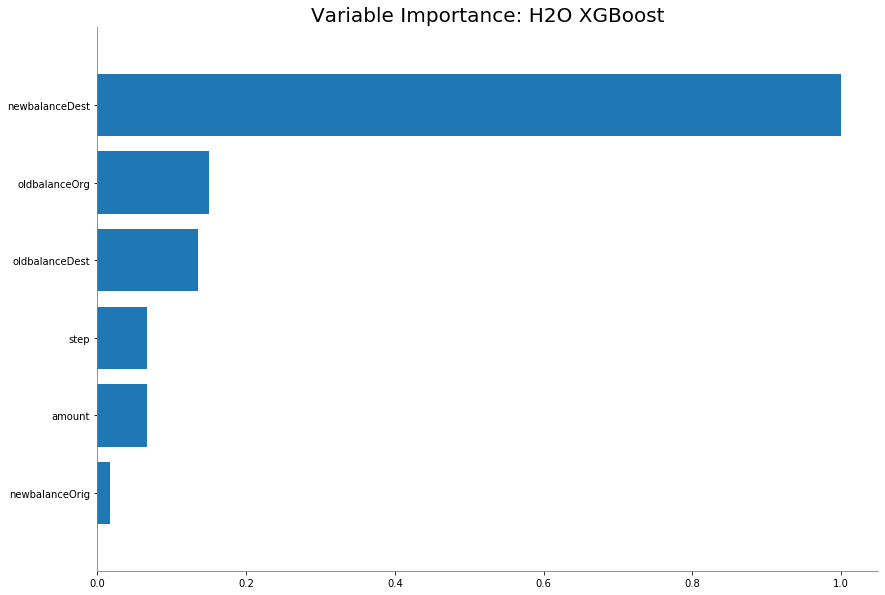

In [18]:
leader_model.varimp_plot()

In [24]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model

model_auprc_map = {'Model Id' : [], 'AUPRC' : []}
for mid in model_ids:
    model = h2o.get_model(mid)
    # print('model {} pr_auc = {}'.format(mid, model.pr_auc(test)))
    model_auprc_map['Model Id'].append(mid)
    model_auprc_map['AUPRC'].append(model.pr_auc(train))
model_auprc_df = pd.DataFrame(model_auprc_map)
model_auprc_df.sort_values(['AUPRC'], ascending=0, inplace=True)
model_auprc_df.head(20)

,Model Id,AUPRC
3,XGBoost_2_AutoML_20191113_110031,0.937313
1,XGBoost_1_AutoML_20191113_110031,0.887348
0,XGBoost_3_AutoML_20191113_110031,0.873075
7,StackedEnsemble_AllModels_AutoML_20191113_110031,0.783424
4,StackedEnsemble_BestOfFamily_AutoML_20191113_110031,0.781576
6,DRF_1_AutoML_20191113_110031,0.731056
5,GBM_5_AutoML_20191113_110031,0.728589
10,GBM_2_AutoML_20191113_110031,0.717498
9,GBM_3_AutoML_20191113_110031,0.711645
8,GBM_1_AutoML_20191113_110031,0.619219


In [25]:
best_auprc_model_id = model_auprc_df.iloc[0, 0]
best_auprc_model = h2o.get_model(best_auprc_model_id)

In [26]:
best_auprc_model.model_performance(test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 5.499435271950384e-05
RMSE: 0.007415817737748403
LogLoss: 0.00033355255000882547
Mean Per-Class Error: 0.00032052188504572143
AUC: 0.9999961892746092
pr_auc: 0.9747907611211869
Gini: 0.9999923785492184

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6459013819694519: 


,,0,1,Error,Rate
0,0,106075.0,2.0,0.0,(2.0/106077.0)
1,1,2.0,849.0,0.0024,(2.0/851.0)
2,Total,106077.0,851.0,0.0,(4.0/106928.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.645901,0.997650,206.0
1,max f2,0.645901,0.997650,206.0
2,max f0point5,0.645901,0.997650,206.0
3,max accuracy,0.645901,0.999963,206.0
4,max precision,0.999612,1.000000,0.0
5,max recall,0.008270,1.000000,254.0
6,max specificity,0.999612,1.000000,0.0
7,max absolute_mcc,0.645901,0.997631,206.0
8,max min_per_class_accuracy,0.008270,0.999359,254.0
9,max mean_per_class_accuracy,0.008270,0.999679,254.0



Gains/Lift Table: Avg response rate:  0.80 %, avg score:  0.80 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010007,0.003541,99.93271,99.932710,0.795327,0.791096,0.795327,0.791096,1.0,1.0,9893.271028,9893.271028
1,,2,0.020004,0.000973,0.00000,49.989715,0.000000,0.001702,0.397849,0.396584,0.0,1.0,-100.000000,4898.971482
2,,3,0.030001,0.000386,0.00000,33.331671,0.000000,0.000628,0.265274,0.264640,0.0,1.0,-100.000000,3233.167082
3,,4,0.040008,0.000236,0.00000,24.994857,0.000000,0.000298,0.198925,0.198523,0.0,1.0,-100.000000,2399.485741
4,,5,0.050015,0.000156,0.00000,19.994016,0.000000,0.000190,0.159125,0.158842,0.0,1.0,-100.000000,1899.401645
5,,6,0.100002,0.000069,0.00000,9.999813,0.000000,0.000097,0.079585,0.079492,0.0,1.0,-100.000000,899.981296
6,,7,0.150026,0.000048,0.00000,6.665503,0.000000,0.000058,0.053048,0.053006,0.0,1.0,-100.000000,566.550305
7,,8,0.200041,0.000030,0.00000,4.998971,0.000000,0.000037,0.039785,0.039762,0.0,1.0,-100.000000,399.897148
8,,9,0.302783,0.000022,0.00000,3.302693,0.000000,0.000025,0.026285,0.026278,0.0,1.0,-100.000000,230.269335
9,,10,0.399998,0.000015,0.00000,2.500012,0.000000,0.000019,0.019897,0.019896,0.0,1.0,-100.000000,150.001169


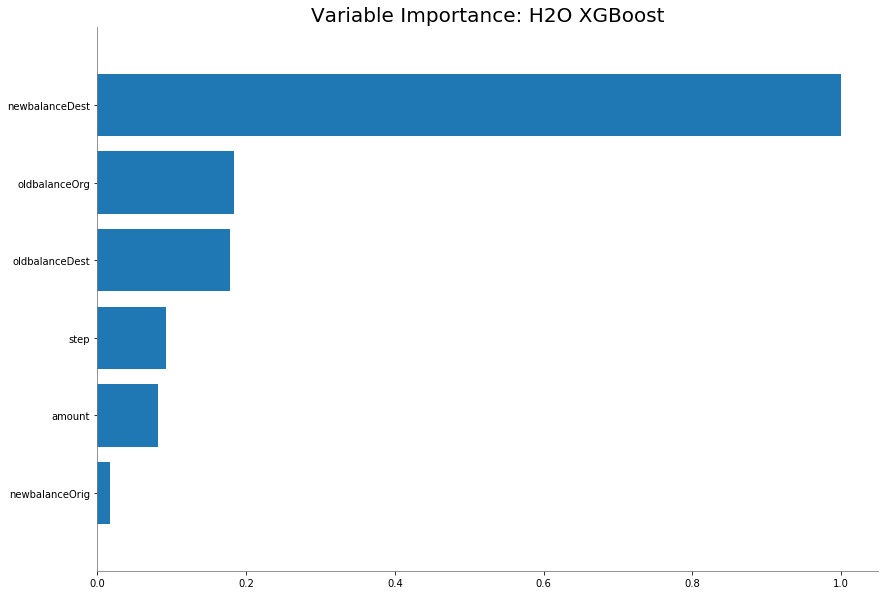

In [22]:
best_auprc_model.varimp_plot()